# Homework 3 #
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***.

Here, I have imported the dataset "cleaned-sleep1". There exist 61 observtions in the dataset. I chose to use the numerical column "Sleep" ("Sleep" records the hours of sleeps a person get per night).

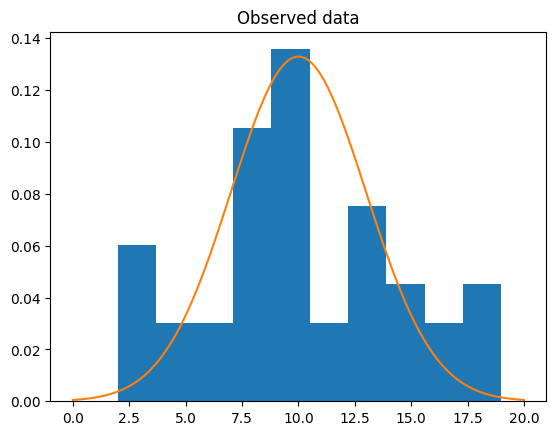

In [152]:

import pandas as pd
import os
import openpyxl
from google.colab import files
#Import the dataset
uploaded_files = files.upload()
csv = pd.read_csv('cleaned_sleep1.csv')
import numpy as np;
import statistics
from scipy import stats; import matplotlib.pyplot as plt
sleep=csv.loc[:,"Sleep"]
sleep_list = sleep.tolist()
sleep1 = []
#I noticed that I have an outlier 20000 in this dataset,
# I will remove it for now
for i in sleep_list:
  if int(i)!=20000:
    sleep1.append(int(i))
s_mean=statistics.mean(sleep1)
s_sd=statistics.stdev(sleep1)
#Plotting the histogram for my samples
plt.hist(sleep1, density=True)
Rpm = np.linspace(0,20,100)
theta_true,phi_true = 10,3;
true_data_model = stats.norm(loc=theta_true,scale=phi_true)
plt.plot(Rpm, true_data_model.pdf(Rpm));
plt.title("Observed data")


I plotted the data from the column "Sleep" and it appears to be a normal distribution. Then, I will use the normal distribution as my likelihood. As a result, we will be using the normal-Gamma Model.

|For Normal-Gamma: The Full (Joint) Posterior Distribuition||$\quad\quad\;\;$Full Conditional Distributions
|-|:-:|-|
|$$p(\theta,\phi|x) \color{gray}{= p(\theta,\phi|x,\theta_0,\tau,\alpha,\beta)}\quad\quad\quad$$||$$\scriptsize
\begin{align*}
p(\theta|x,\theta_0,\tau, \phi) &={} \text{N}\left(\frac{\left(\tau \theta_0+\phi\sum_{i=1}^{n}x_{i}\right)}{(\tau+n\phi)}, \sigma^{-2}=\tau+n\phi \right)\\
p(\phi|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\alpha+\frac{n}{2}, \beta+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)
\end{align*}$$
|

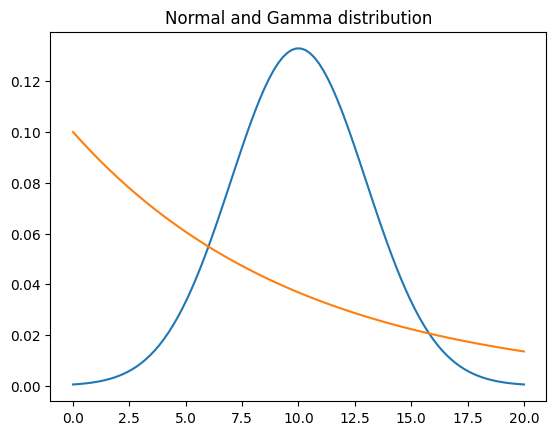

In [153]:

alpha,beta = 1,0.1
theta_0=10
tau=3
theta_prior = stats.norm(loc=theta_0, scale=tau)
phi_prior = stats.gamma(a=alpha, scale=1/beta)
plt.title('Normal and Gamma distribution')
plt.plot(Rpm, theta_prior.pdf(Rpm));
plt.plot(Rpm, phi_prior.pdf(Rpm));

Posterior Inference with PYMC:

In [155]:
import pymc as pm;
normal_gamma_model = pm.Model()
with normal_gamma_model:
    theta = pm.Normal("theta", mu=10, sigma=3)
    phi = pm.Gamma("phi", alpha=1, beta=0.1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=sleep1)

In [157]:
with normal_gamma_model:
    idata_HMC = pm.sample()

HMC Split-Rhats {'theta': 1.0039, 'phi': 1.001} | 

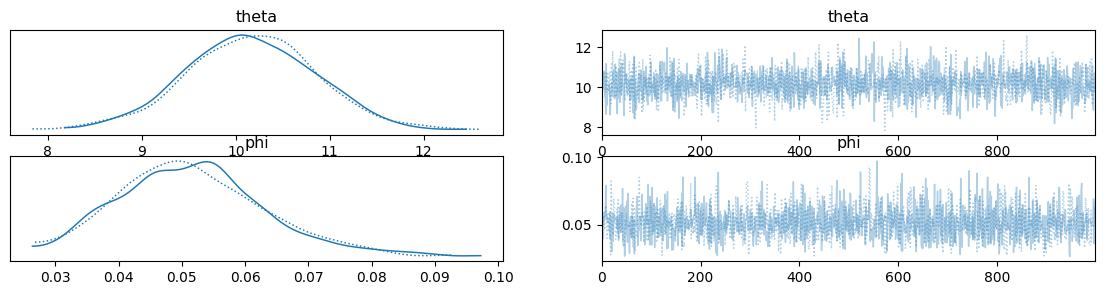

In [158]:
import arviz as az;
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]);
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ');

Since my calculated Split-Rhsts is not greater than 1.05, then I'm satisfied to claim that my markov chain has converged to stationary distribution.

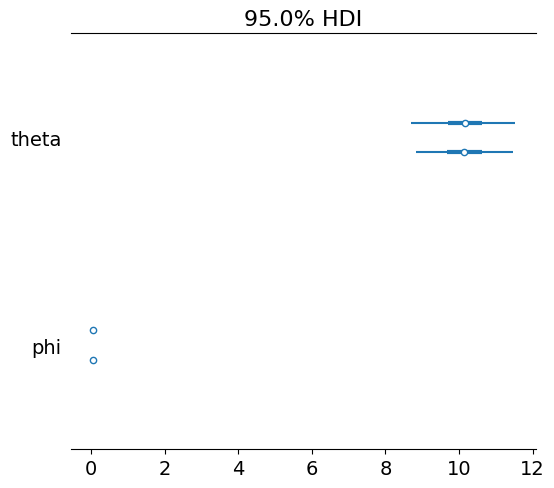

In [159]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_forest(idata_HMC, var_names=["theta","phi"], combined=False, hdi_prob=0.95);


Here, we are calculating the 95% credible interval. This tells us that there is a 95% chance that the true theta would lie within the interval of the bolded blue line (given the evidence provided by the observed data). My phi interval looks wrong, more investigation needed.

2. Find a different column of data for which a ***normal-gamma specification*** isn't justified.

Here, I imported the dataset "patient_helth". There exist 149 observations in this dataset. I chose to use column "Diabetic".

(array([76.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 73.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

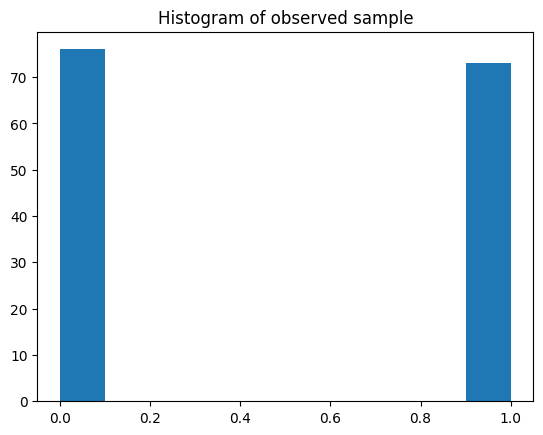

In [99]:
from scipy import stats
import numpy as np
df = pd.read_csv('patient_health.csv')
# Access the "AlcoholLevel" column
patient = df["Diabetic"]

# Calculate the mean and standard deviation
# Plot the histogram
plt.title('Histogram of observed sample')
plt.hist(patient)

3. Create a different `PyMC` specification that IS appropriate for this new data column:

We notice that "Diabetic" take notes on whether a patient is diabetic or not, and it record 0 if the patient is not diabetic, and 1 if the patient is diabetic. This looks to be an binomial Distribution. As a result, we can no longer apply the normal-gamma specification. Then, we choose our likelihood to be an binomial distribution; and we will be applying an beta-binomial specifiction.

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains.

In [100]:
import pymc as pm;
beta_binomial_model = pm.Model()
#Here, we have a binomial likelihood
with beta_binomial_model:
    theta = pm.Beta("theta", alpha=1, beta=1)
    x_obs = pm.Binomial("likelihood", n=1, p=theta, observed=patient)

In [101]:
with beta_binomial_model:
    idata_HMC1 = pm.sample()

HMC Split-Rhats {'theta': 1.0005}  

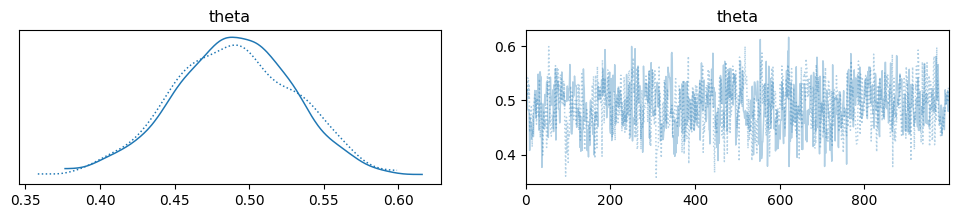

In [142]:
import arviz as az;
figsize=(14,3)
az.plot_trace(idata_HMC1);
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC1).items()}, end='  ');

Since my calculated Split-Rhsts is not greater than 1.05, then I'm satisfied to claim that my markov chain has converged to stationary distribution.

An analysis of the MCMC chains.

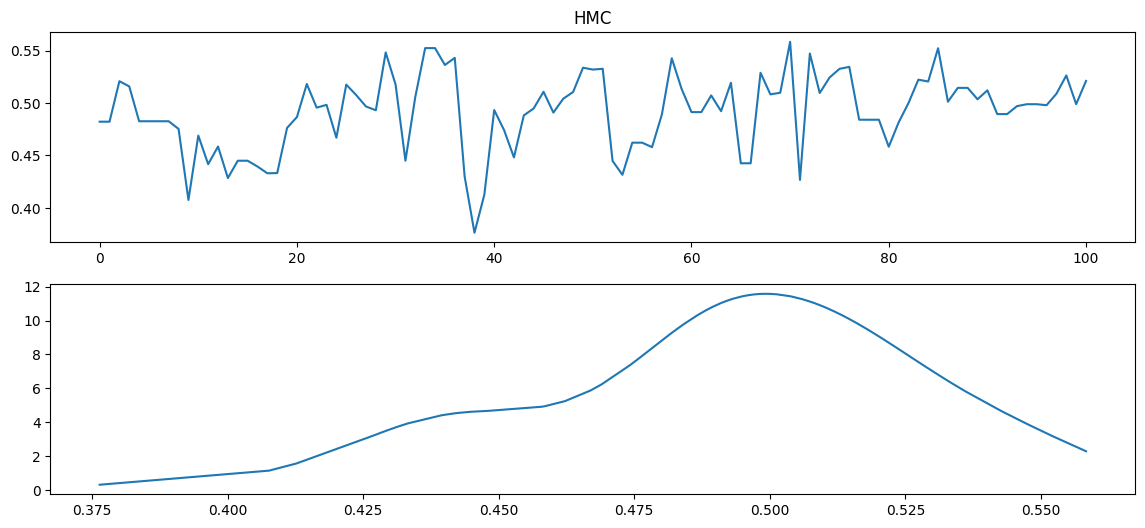

In [146]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,1, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain1 = idata_HMC1.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values;
mcmc_chain_sorted1 = sorted(mcmc_chain1)
ax[0].plot(mcmc_chain1);
ax[1].plot(mcmc_chain_sorted1,gaussian_kde(mcmc_chain_sorted1)(mcmc_chain_sorted1)); ax[0].set_title("HMC");


Here, we are seeing the first 100 samples form the HMC methods (no abnormal activity detected here).

Autocorrelation for HMC (MCMC) chain 0.42570581232822885


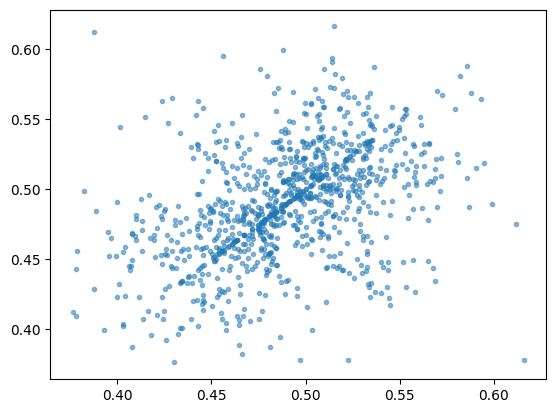

In [147]:
import numpy as np; import matplotlib.pyplot as plt;
max_mcmc_samples = 1000
mcmc_chain1 = idata_HMC1.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values;
mcmc_chain_one_step_ahead1 = idata_HMC1.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values;
plt.plot(mcmc_chain1, mcmc_chain_one_step_ahead1, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain1,mcmc_chain_one_step_ahead1)[0,1])

Here, we are calculating hte autcorrelation for HMC chains; our autocorrelation is 0.42 (0.42 is not a super high value, which means that our current datapoint is not highly correated with the last datapoint)

In [132]:
import arviz as az;
print("number of MCMC samples:", idata_HMC1.posterior['theta'].values.flatten().shape[-1])
az.summary(idata_HMC1, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.49,0.04,0.41,0.56,0.0,0.0,662.82,1095.82,1.0


Here, we are calculating the effective datapoints out of all the datapoint. We see that our total effective datapoint out of 2000 is 662.82

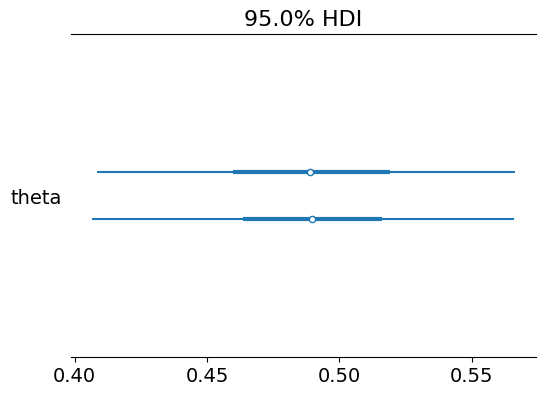

In [133]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_forest(idata_HMC1, var_names=["theta"], combined=False, hdi_prob=0.95);


Lastly, we have created a 95% credible interval for our theta.
This tells us that there is a 95% chance that the true theta would lie within the interval of the bolded blue line (given the evidence provided by the observed data).